<a href="https://colab.research.google.com/github/LeoFernanndes/estudos/blob/main/SimulationChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [72]:
simulation_train_url = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/simulation_train_dataset.csv'
train = pd.read_csv(simulation_train_url, sep=';')
train

JOBID         DAY      HOUR  ... DATACHECK_TIME ELAPSEDTIME  TZC FINAL
0      829925  01/02/2019  10:04:18  ...          70.50        2920    0.03980
1      829727  01/02/2019  09:18:55  ...          31.20        6880    0.04310
2      829909  01/02/2019  10:03:08  ...         413.00        6560    0.03870
3      829842  01/02/2019  09:49:19  ...           9.05       11200    0.06840
4      829844  01/02/2019  09:49:50  ...          13.40       15300    0.04320
...       ...         ...       ...  ...            ...         ...        ...
89107  998154  07/31/2020  23:57:48  ...         844.00       60000    0.01890
89108    4950  07/31/2020  20:25:41  ...         906.00       73500    0.02170
89109    4801  07/31/2020  19:25:04  ...         909.00      103000    0.02980
89110    4890  07/31/2020  19:46:42  ...         924.00      102000    0.02960
89111  992614  07/31/2020  23:58:26  ...          28.30      129000    0.00845

[89112 rows x 22 columns]

In [3]:
train.describe()

JOBID     PRECISION  ...    ELAPSEDTIME     TZC FINAL
count   89112.000000  89112.000000  ...   89112.000000  89112.000000
mean   518106.915544      1.080180  ...   20768.528705      0.036477
std    300137.877133      0.271573  ...   19118.843759      0.085775
min       180.000000      1.000000  ...    1810.000000      0.002600
25%    238358.750000      1.000000  ...    6260.000000      0.017200
50%    544904.500000      1.000000  ...   14800.000000      0.031200
75%    787679.750000      1.000000  ...   29200.000000      0.040400
max    999978.000000      2.000000  ...  129000.000000      7.250000

[8 rows x 13 columns]

In [4]:
train.isnull().sum()

JOBID             0
DAY               0
HOUR              0
VERSION           0
PERFORMANCE       0
PRECISION         0
MPLINK            0
NTNU              0
MPLINK+NTNU       0
MBS               0
RUNEND            0
TIMESTEP          0
NBNODES           0
NBELEM1D          0
NBELEM2D          0
NBELEM3D          0
CLUSTER           0
NBSERVERS         0
NBCORE            0
DATACHECK_TIME    0
ELAPSEDTIME       0
TZC FINAL         0
dtype: int64

Uma olhada bem por cima ja adianta o nosso lado por não haverem valores nulos no dataset

## Overview das variáveis

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


train.corr()

JOBID  PRECISION  ...  ELAPSEDTIME  TZC FINAL
JOBID           1.000000  -0.007492  ...     0.024352  -0.009469
PRECISION      -0.007492   1.000000  ...     0.047381   0.052490
RUNEND         -0.012611   0.121266  ...     0.141224  -0.014766
TIMESTEP       -0.001983  -0.133570  ...    -0.067103   0.007769
NBNODES         0.011322  -0.221953  ...     0.438360  -0.186395
NBELEM1D        0.029108   0.093415  ...     0.602636  -0.159429
NBELEM2D        0.011375  -0.228704  ...     0.429574  -0.185282
NBELEM3D        0.010021  -0.162246  ...     0.433753  -0.156958
NBSERVERS       0.033458  -0.091619  ...     0.369689  -0.163058
NBCORE          0.031199  -0.095970  ...     0.389453  -0.169439
DATACHECK_TIME  0.009305  -0.191783  ...     0.397978  -0.143281
ELAPSEDTIME     0.024352   0.047381  ...     1.000000  -0.087013
TZC FINAL      -0.009469   0.052490  ...    -0.087013   1.000000

[13 rows x 13 columns]

In [6]:
from sklearn.preprocessing import MinMaxScaler

# a closer look into the numerical features
numerical_features = train.dtypes[train.dtypes != 'object'].index.values

mm = MinMaxScaler()
numerical_train_scaled = mm.fit_transform(train[numerical_features])
numerical_train_scaled = pd.DataFrame(numerical_train_scaled, columns=numerical_features)
numerical_train_scaled[['ELAPSEDTIME', 'TZC FINAL']] = train[['ELAPSEDTIME', 'TZC FINAL']]

numerical_train_scaled

JOBID  PRECISION    RUNEND  ...  DATACHECK_TIME  ELAPSEDTIME  TZC FINAL
0      0.829913        0.0  0.000470  ...        0.022821         2920    0.03980
1      0.829715        0.0  0.003168  ...        0.010018         6880    0.04310
2      0.829897        0.0  0.000232  ...        0.134401         6560    0.03870
3      0.829830        1.0  0.003170  ...        0.002802        11200    0.06840
4      0.829832        0.0  0.005073  ...        0.004219        15300    0.04320
...         ...        ...       ...  ...             ...          ...        ...
89107  0.998176        0.0  0.002375  ...        0.274812        60000    0.01890
89108  0.004771        0.0  0.002692  ...        0.295011        73500    0.02170
89109  0.004622        0.0  0.002692  ...        0.295988       103000    0.02980
89110  0.004711        0.0  0.002692  ...        0.300875       102000    0.02960
89111  0.992635        1.0  0.055551  ...        0.009073       129000    0.00845

[89112 rows x 13 columns]

Os coeficientes de correlação se mantém os mesmos seja para os valores padrão seja para valores escalados de 0 a 1

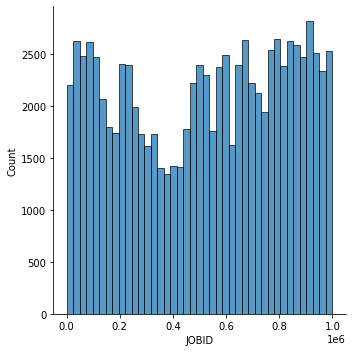

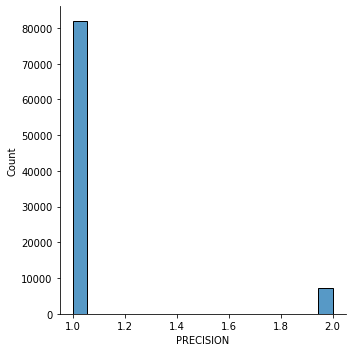

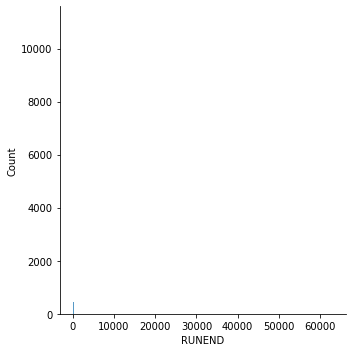

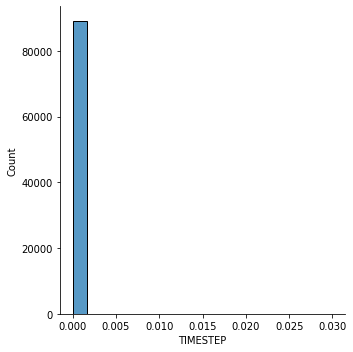

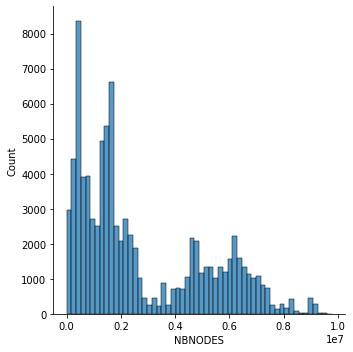

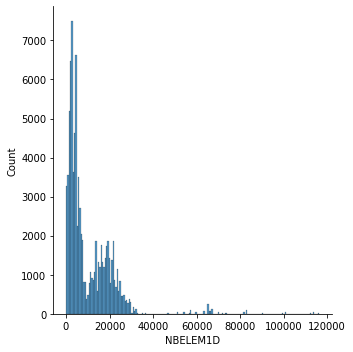

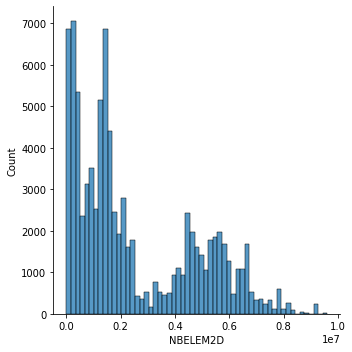

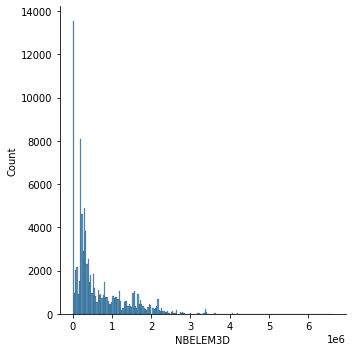

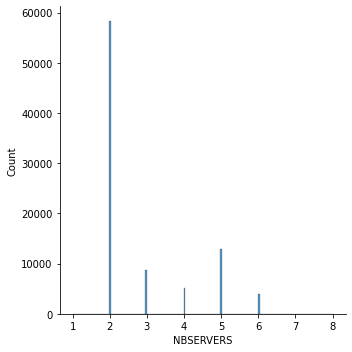

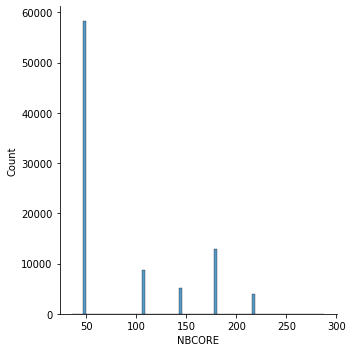

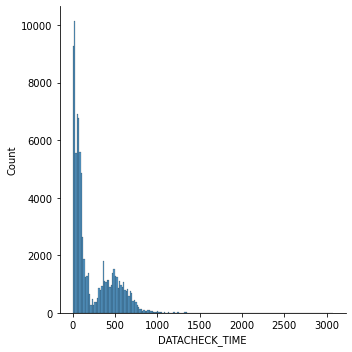

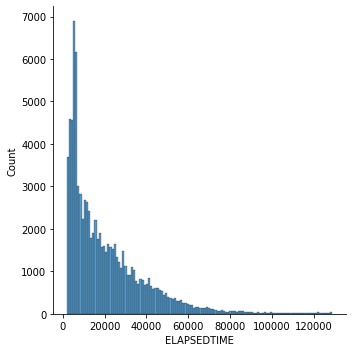

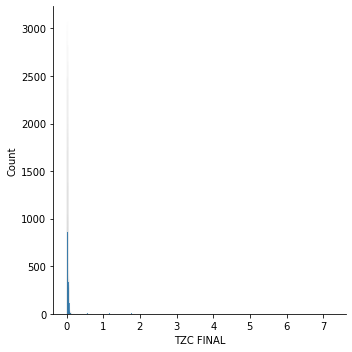

In [7]:
import seaborn as sns

# let us now plot numerical features distributions
for feature in numerical_features:
  sns.displot(train[feature])

In [8]:
# taking a glampse into categorical features
categorical_features = train.dtypes[train.dtypes == 'object'].index.values

categorical_train = train[categorical_features].copy()
categorical_train[['ELAPSEDTIME', 'TZC FINAL']] = train[['ELAPSEDTIME', 'TZC FINAL']]
categorical_train

DAY      HOUR   VERSION  ... CLUSTER ELAPSEDTIME TZC FINAL
0      01/02/2019  10:04:18    2012.7  ...    HPC1        2920   0.03980
1      01/02/2019  09:18:55    2012.7  ...    HPC1        6880   0.04310
2      01/02/2019  10:03:08   2016.05  ...    HPC1        6560   0.03870
3      01/02/2019  09:49:19    2012.7  ...    HPC1       11200   0.06840
4      01/02/2019  09:49:50    2012.7  ...    HPC1       15300   0.04320
...           ...       ...       ...  ...     ...         ...       ...
89107  07/31/2020  23:57:48  2018.0.1  ...    HPC3       60000   0.01890
89108  07/31/2020  20:25:41  2018.0.1  ...    HPC3       73500   0.02170
89109  07/31/2020  19:25:04  2018.0.1  ...    HPC3      103000   0.02980
89110  07/31/2020  19:46:42  2018.0.1  ...    HPC3      102000   0.02960
89111  07/31/2020  23:58:26   2016.05  ...    HPC3      129000   0.00845

[89112 rows x 11 columns]

In [9]:
for feature in categorical_features:
  print(categorical_train.groupby(by=feature)['ELAPSEDTIME'].median())
  print('')

DAY
01/02/2019    15300
01/02/2020    11200
01/03/2019    15300
01/03/2020    10750
01/04/2019    10900
              ...  
12/25/2019    25100
12/26/2019    25100
12/27/2019    23300
12/30/2019    25700
12/31/2019    38800
Name: ELAPSEDTIME, Length: 527, dtype: int64

HOUR
00:00:01    33700
00:00:03    15600
00:00:52     9910
00:01:02    14700
00:01:05     5630
            ...  
23:59:00    24300
23:59:15    28100
23:59:31     4740
23:59:36    42900
23:59:42    77000
Name: ELAPSEDTIME, Length: 45418, dtype: int64

VERSION
2012.7      11100
2016.01      6610
2016.05     13900
2016.06     24000
2018.0      29900
2018.0.1    16900
2019        11700
2019.0      21100
2019.0.1    18700
2019.0.2    21100
Name: ELAPSEDTIME, dtype: int64

PERFORMANCE
COCKPIT        7420
ECE           29200
FRONT         33400
OVERSLAM       9805
PEDESTRIAN     5820
POLE          22950
RCAR          18600
REAR          20800
SIDE          27500
UNKNOWN       13600
WHEEL         67300
Name: ELAPSEDTIME, dtype: 

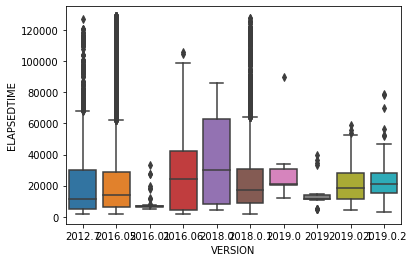

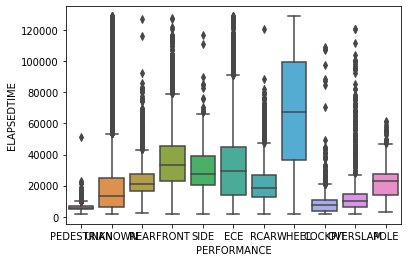

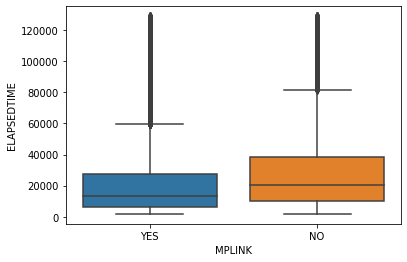

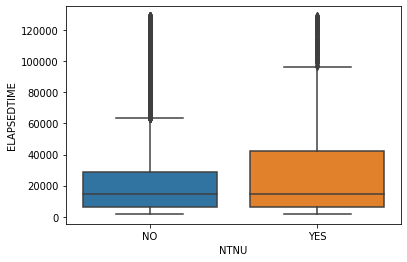

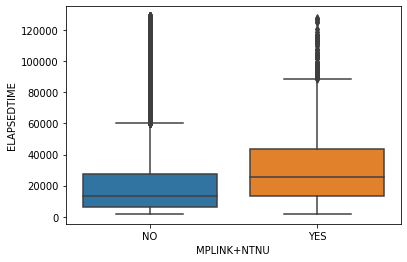

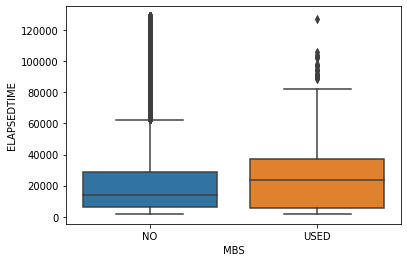

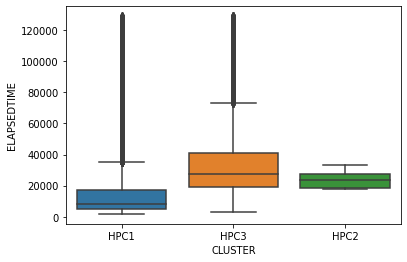

In [10]:
# now let's see the same values distributed as boxplots

ignored_categorical_for_boxplot = ['DAY', 'HOUR']

for feature in categorical_features:
  if feature not in ignored_categorical_for_boxplot:
    sns.boxplot(x=feature, y='ELAPSEDTIME', data=categorical_train)
    plt.show()

In [11]:
# sns.pairplot(train)

## Avaliando as variáveis individualmente

### Precision

Accuracy of calculations: single or double precision.  Double precision calculations are expected to be slower. In usual business practice, double precision is recommended above 1 million simulation cycles (theoretical (maximum) number of cycles = RUNNING/TIMESTEP), but the simulation may be shorter if a termination condition is met.

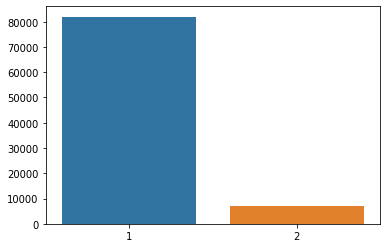

In [12]:
# plotando a frequencia das classes
frequency = train['PRECISION'].value_counts()
sns.barplot(x=train['PRECISION'].value_counts().index, y=train['PRECISION'].value_counts().values)
plt.show()

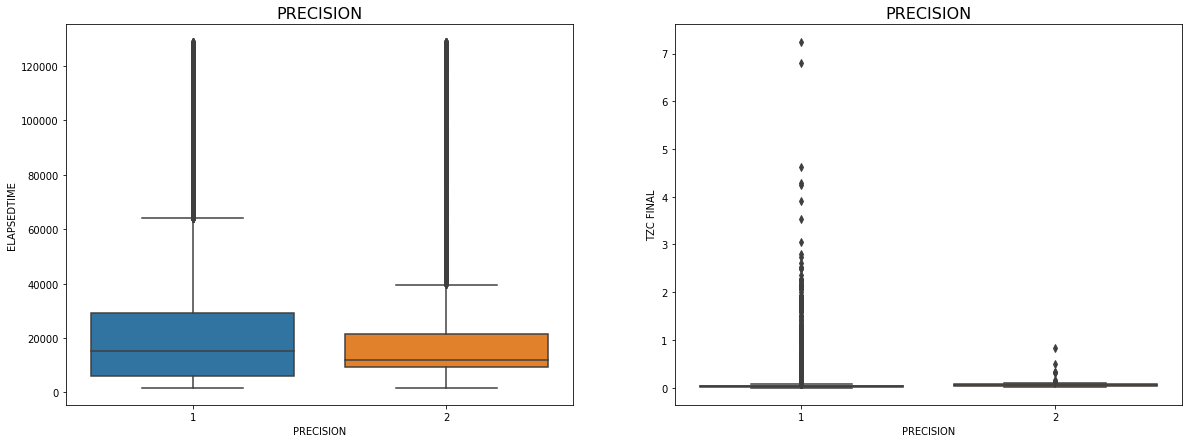

In [13]:
feature_boxplot = 'PRECISION'

plt.figure(figsize=(20, 7))

color_palette = {1: 'orange',
                 2: 'blue'}

plt.subplot(1,2,1)
sns.boxplot(x=feature_boxplot , y='ELAPSEDTIME', data=train)
plt.title(f'{feature_boxplot}', size=16)

plt.subplot(1,2,2)
sns.boxplot(x=feature_boxplot , y='TZC FINAL', data=train)
plt.title(f'{feature_boxplot}', size=16)
plt.show()

plt.show()

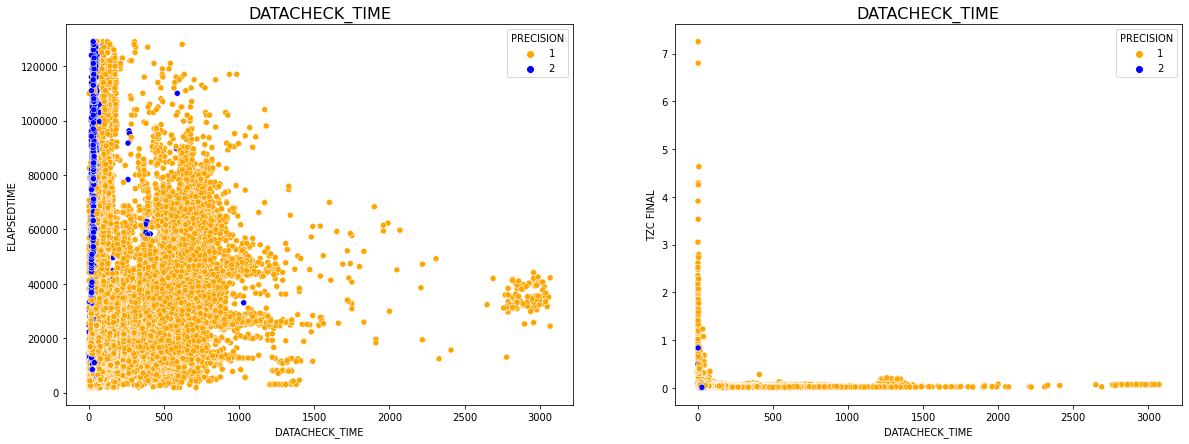

In [14]:
# plotando os scatterplots de cada variável numérica com ELAPSEDTIME e TZC FINAL
feature = 'DATACHECK_TIME'

plt.figure(figsize=(20, 7))

color_palette = {1: 'orange',
                 2: 'blue'}

plt.subplot(1,2,1)
sns.scatterplot(x=feature, y='ELAPSEDTIME', hue='PRECISION', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)

plt.subplot(1,2,2)
sns.scatterplot(x=feature, y='TZC FINAL', hue='PRECISION', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)
plt.show()

plt.show()

Simulações de precisão dupla (mais complexas) têm a primeira iteração (datacheck_time) muito rápida. Uma possivel causa desse efeito é a alta capacidade de cálculo usada em simulações complexas, mas como a primeira iteração é a mais simples de todas, quanto mais complexa a simulação, menor o datacheck time.

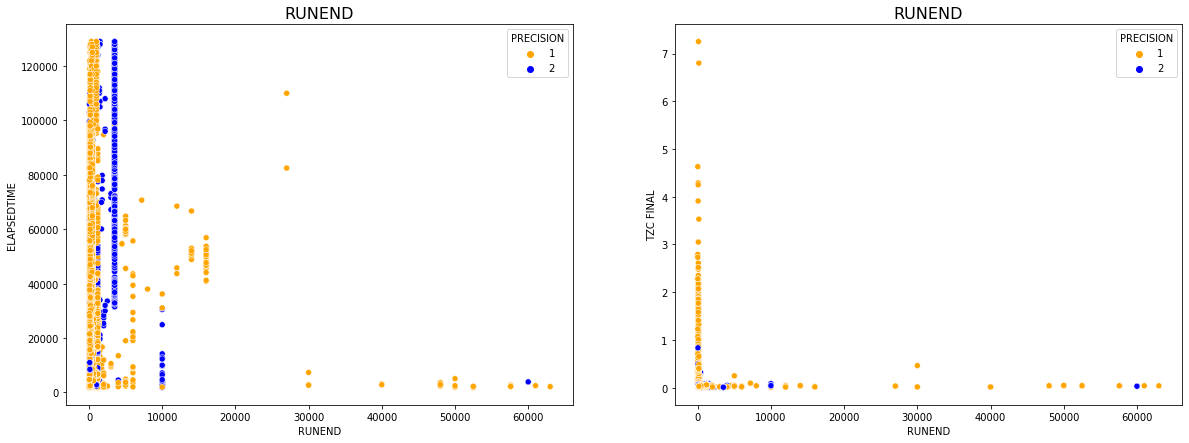

In [15]:
feature = 'RUNEND'

plt.figure(figsize=(20, 7))

color_palette = {1: 'orange',
                 2: 'blue'}

plt.subplot(1,2,1)
sns.scatterplot(x=feature, y='ELAPSEDTIME', hue='PRECISION', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)

plt.subplot(1,2,2)
sns.scatterplot(x=feature, y='TZC FINAL', hue='PRECISION', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)
plt.show()

plt.show()

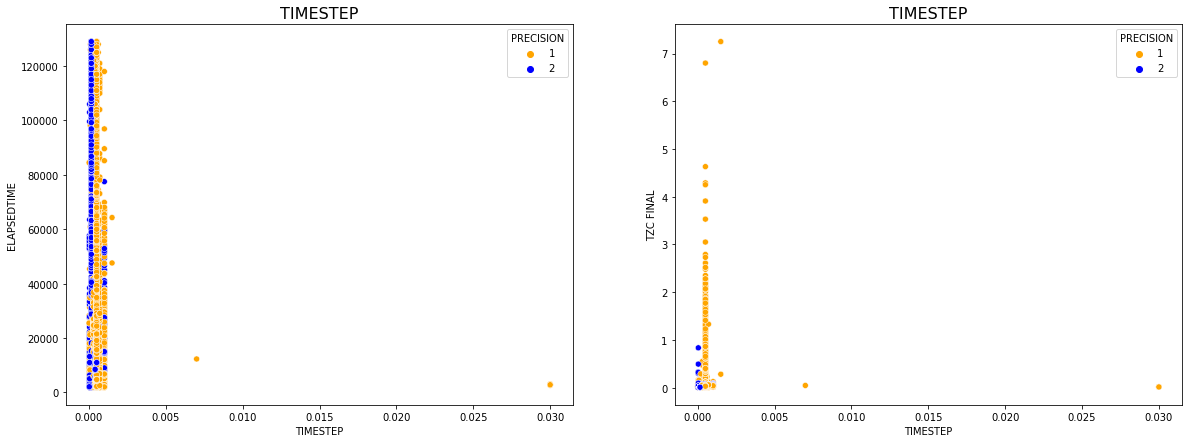

In [16]:
feature = 'TIMESTEP'

plt.figure(figsize=(20, 7))

color_palette = {1: 'orange',
                 2: 'blue'}

plt.subplot(1,2,1)
sns.scatterplot(x=feature, y='ELAPSEDTIME', hue='PRECISION', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)

plt.subplot(1,2,2)
sns.scatterplot(x=feature, y='TZC FINAL', hue='PRECISION', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)
plt.show()

plt.show()

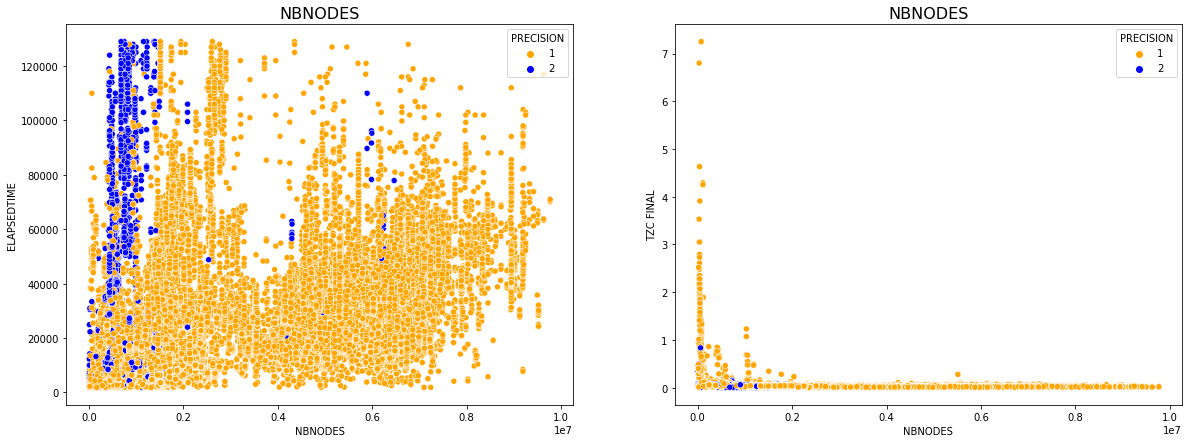

In [17]:
feature = 'NBNODES'

plt.figure(figsize=(20, 7))

color_palette = {1: 'orange',
                 2: 'blue'}

plt.subplot(1,2,1)
sns.scatterplot(x=feature, y='ELAPSEDTIME', hue='PRECISION', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)

plt.subplot(1,2,2)
sns.scatterplot(x=feature, y='TZC FINAL', hue='PRECISION', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)
plt.show()

plt.show()

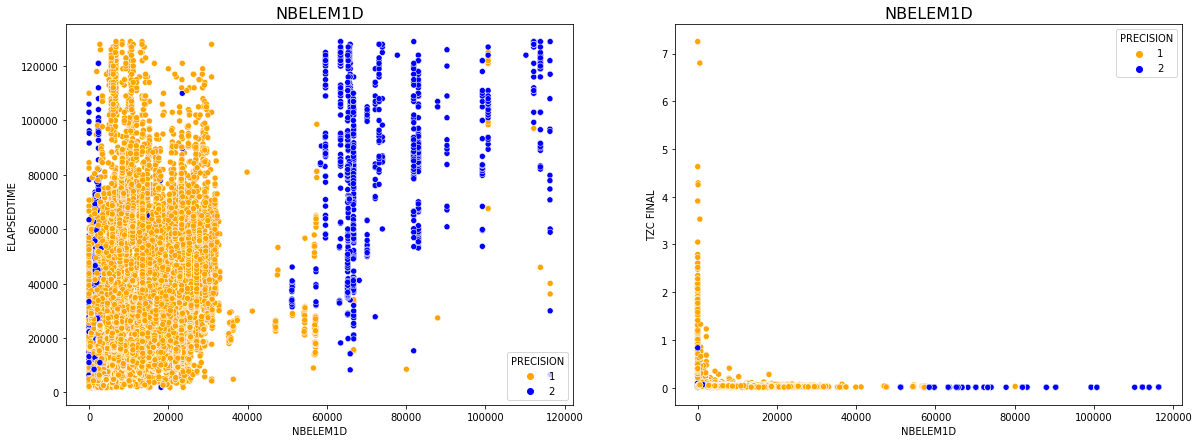

In [18]:
feature = 'NBELEM1D'

plt.figure(figsize=(20, 7))

color_palette = {1: 'orange',
                 2: 'blue'}

plt.subplot(1,2,1)
sns.scatterplot(x=feature, y='ELAPSEDTIME', hue='PRECISION', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)

plt.subplot(1,2,2)
sns.scatterplot(x=feature, y='TZC FINAL', hue='PRECISION', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)
plt.show()

plt.show()

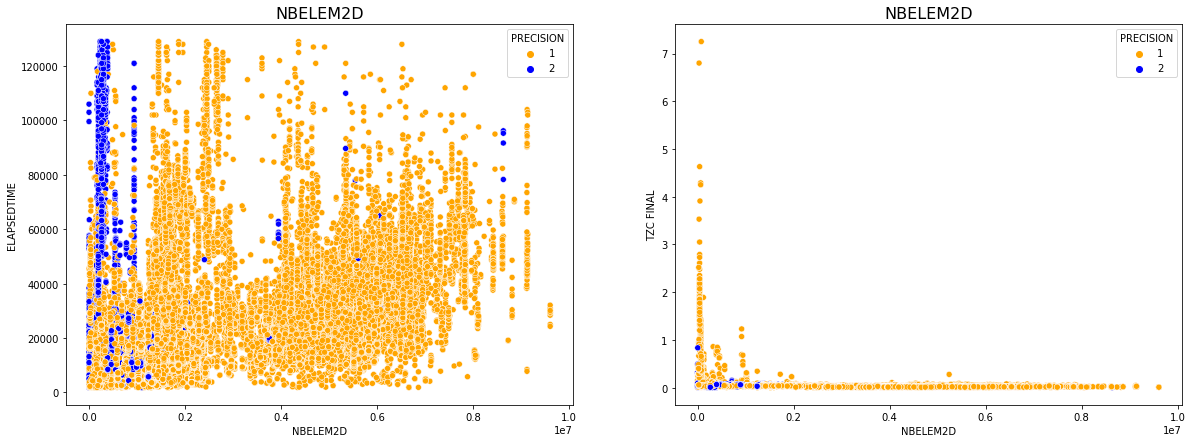

In [19]:
feature = 'NBELEM2D'

plt.figure(figsize=(20, 7))

color_palette = {1: 'orange',
                 2: 'blue'}

plt.subplot(1,2,1)
sns.scatterplot(x=feature, y='ELAPSEDTIME', hue='PRECISION', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)

plt.subplot(1,2,2)
sns.scatterplot(x=feature, y='TZC FINAL', hue='PRECISION', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)
plt.show()

plt.show()

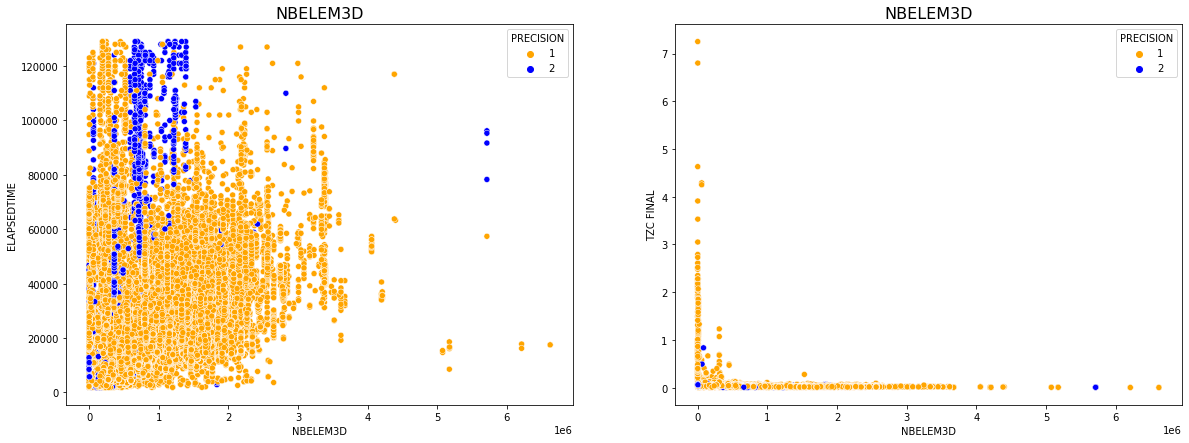

In [20]:
feature = 'NBELEM3D'

plt.figure(figsize=(20, 7))

color_palette = {1: 'orange',
                 2: 'blue'}

plt.subplot(1,2,1)
sns.scatterplot(x=feature, y='ELAPSEDTIME', hue='PRECISION', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)

plt.subplot(1,2,2)
sns.scatterplot(x=feature, y='TZC FINAL', hue='PRECISION', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)
plt.show()

plt.show()

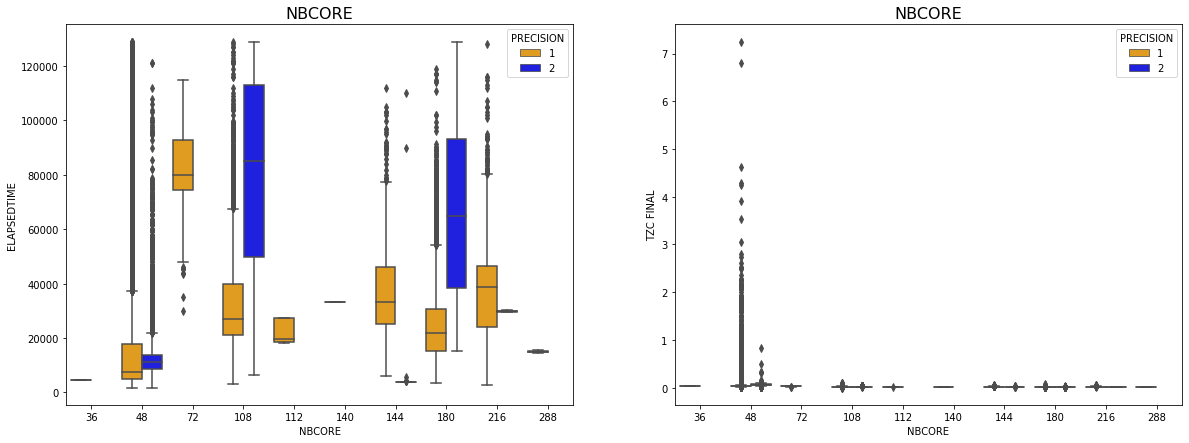

In [21]:
feature = 'NBCORE'

plt.figure(figsize=(20, 7))

color_palette = {1: 'orange',
                 2: 'blue'}

plt.subplot(1,2,1)
sns.boxplot(x=feature, y='ELAPSEDTIME', hue='PRECISION', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)

plt.subplot(1,2,2)
sns.boxplot(x=feature, y='TZC FINAL', hue='PRECISION', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)
plt.show()

plt.show()

### Performance
Type of performance for the given simulation. Different performances have different computational behavior. This column can not always be computed from the input simulation data, in which case "UNKNOWN" is provided.

#### Performance de forma geral

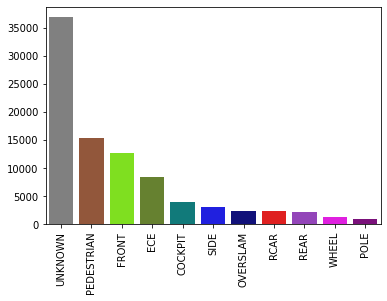

In [22]:
# plotando a frequencia das classes

color_palette = {'UNKNOWN': 'gray',
                 'PEDESTRIAN': 'sienna',
                 'FRONT': 'chartreuse',
                 'ECE': 'olivedrab',
                 'COCKPIT': 'darkcyan',
                 'SIDE': 'blue',
                 'OVERSLAM': 'darkblue',
                 'RCAR': 'red',
                 'REAR': 'darkorchid',
                 'WHEEL': 'fuchsia',
                 'POLE': 'darkmagenta'}

frequency = train['PERFORMANCE'].value_counts()
sns.barplot(x=train['PERFORMANCE'].value_counts().index, y=train['PERFORMANCE'].value_counts().values, palette=color_palette)
plt.xticks(rotation=90)
plt.show()

Dar uma olhada se da pra classificar os desconhecidos pra separar em grupos melhores

In [ ]:
# performance 1 vs other
performance_list = ['UNKNOWN', 'PEDESTRIAN', 'FRONT', 'ECE', 'COCKPIT', 'SIDE', 'OVERSLAM',
       'RCAR', 'REAR', 'WHEEL', 'POLE']

In [23]:
mediana_tempo_simulacao = train.groupby(by='PERFORMANCE').median().sort_values(by="ELAPSEDTIME", ascending=False)['ELAPSEDTIME']
mediana_tempo_simulacao.index.values

array(['WHEEL', 'FRONT', 'ECE', 'SIDE', 'POLE', 'REAR', 'RCAR', 'UNKNOWN',
       'OVERSLAM', 'COCKPIT', 'PEDESTRIAN'], dtype=object)

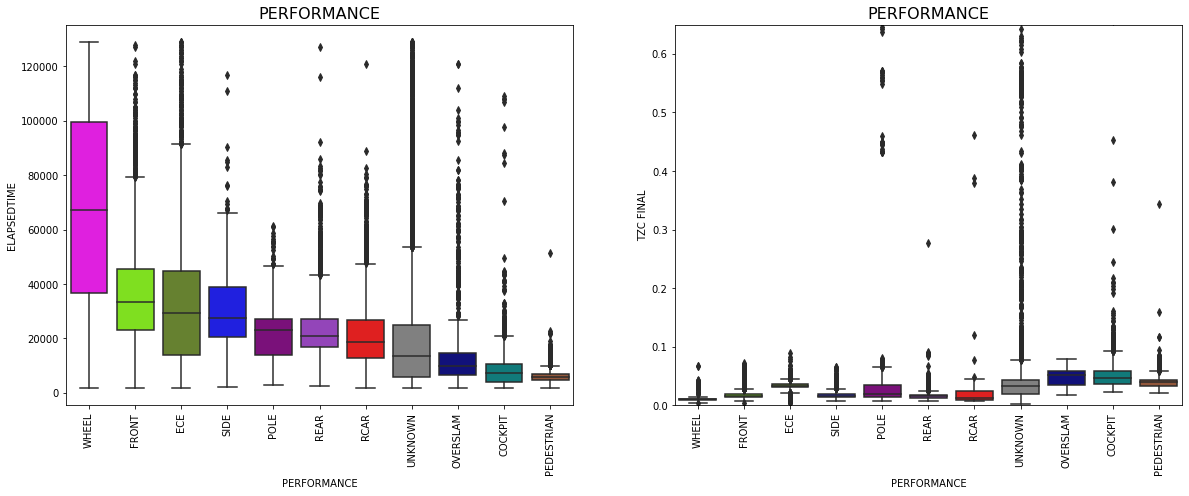

In [24]:
feature_boxplot = 'PERFORMANCE'

plt.figure(figsize=(20, 7))

color_palette = {'UNKNOWN': 'gray',
                 'PEDESTRIAN': 'sienna',
                 'FRONT': 'chartreuse',
                 'ECE': 'olivedrab',
                 'COCKPIT': 'darkcyan',
                 'SIDE': 'blue',
                 'OVERSLAM': 'darkblue',
                 'RCAR': 'red',
                 'REAR': 'darkorchid',
                 'WHEEL': 'fuchsia',
                 'POLE': 'darkmagenta'}

plt.subplot(1,2,1)
sns.boxplot(x=feature_boxplot , y='ELAPSEDTIME', data=train, palette=color_palette,
            order=mediana_tempo_simulacao.index.values)
plt.title(f'{feature_boxplot}', size=16)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.boxplot(x=feature_boxplot , y='TZC FINAL', data=train, palette=color_palette,
            order=mediana_tempo_simulacao.index.values)
plt.title(f'{feature_boxplot}', size=16)
plt.ylim(0, 0.65)
plt.xticks(rotation=90)
plt.show()

plt.show()

Aparentemente um bom caminho pra começar a investigação é tentar entender o comportamento de cada tipo de simulação

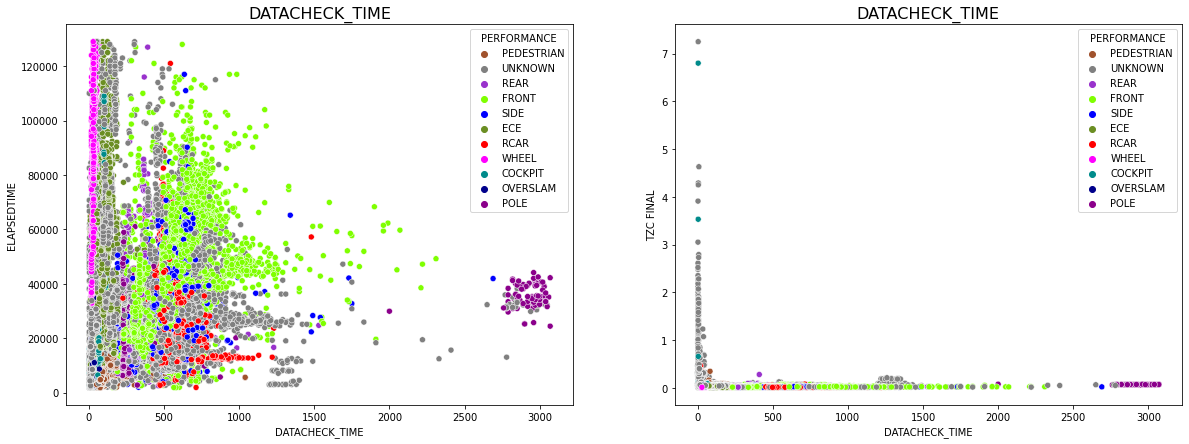

In [25]:
# plotando os scatterplots de cada variável numérica com ELAPSEDTIME e TZC FINAL
feature = 'DATACHECK_TIME'

plt.figure(figsize=(20, 7))

color_palette = {'UNKNOWN': 'gray',
                 'PEDESTRIAN': 'sienna',
                 'FRONT': 'chartreuse',
                 'ECE': 'olivedrab',
                 'COCKPIT': 'darkcyan',
                 'SIDE': 'blue',
                 'OVERSLAM': 'darkblue',
                 'RCAR': 'red',
                 'REAR': 'darkorchid',
                 'WHEEL': 'fuchsia',
                 'POLE': 'darkmagenta'}

plt.subplot(1,2,1)
sns.scatterplot(x=feature, y='ELAPSEDTIME', hue='PERFORMANCE', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)

plt.subplot(1,2,2)
sns.scatterplot(x=feature, y='TZC FINAL', hue='PERFORMANCE', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)
plt.show()

plt.show()

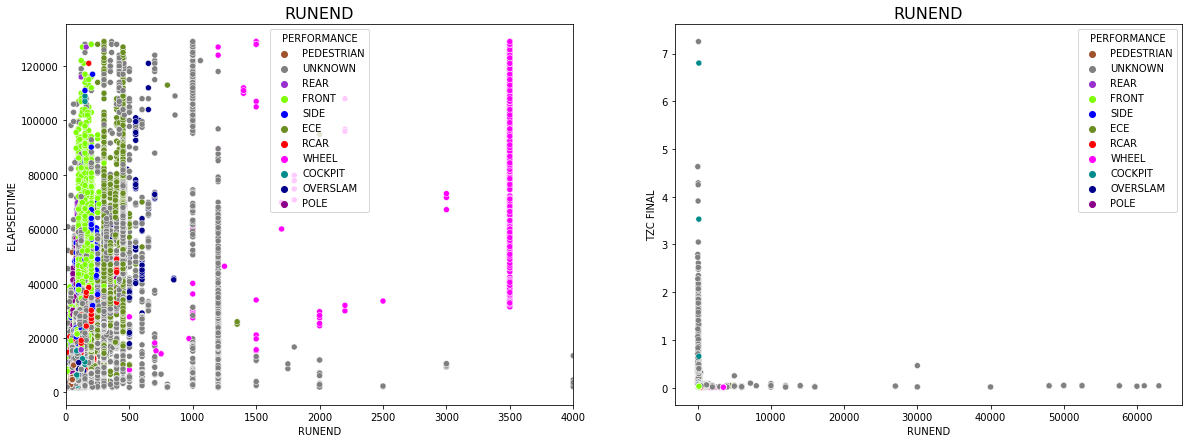

In [26]:
feature = 'RUNEND'

plt.figure(figsize=(20, 7))

color_palette = {'UNKNOWN': 'gray',
                 'PEDESTRIAN': 'sienna',
                 'FRONT': 'chartreuse',
                 'ECE': 'olivedrab',
                 'COCKPIT': 'darkcyan',
                 'SIDE': 'blue',
                 'OVERSLAM': 'darkblue',
                 'RCAR': 'red',
                 'REAR': 'darkorchid',
                 'WHEEL': 'fuchsia',
                 'POLE': 'darkmagenta'}

plt.subplot(1,2,1)
sns.scatterplot(x=feature, y='ELAPSEDTIME', hue='PERFORMANCE', data=train, palette=color_palette)
plt.xlim(0, 4000)
plt.title(f'{feature}', size=16)

plt.subplot(1,2,2)
sns.scatterplot(x=feature, y='TZC FINAL', hue='PERFORMANCE', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)
plt.show()

plt.show()

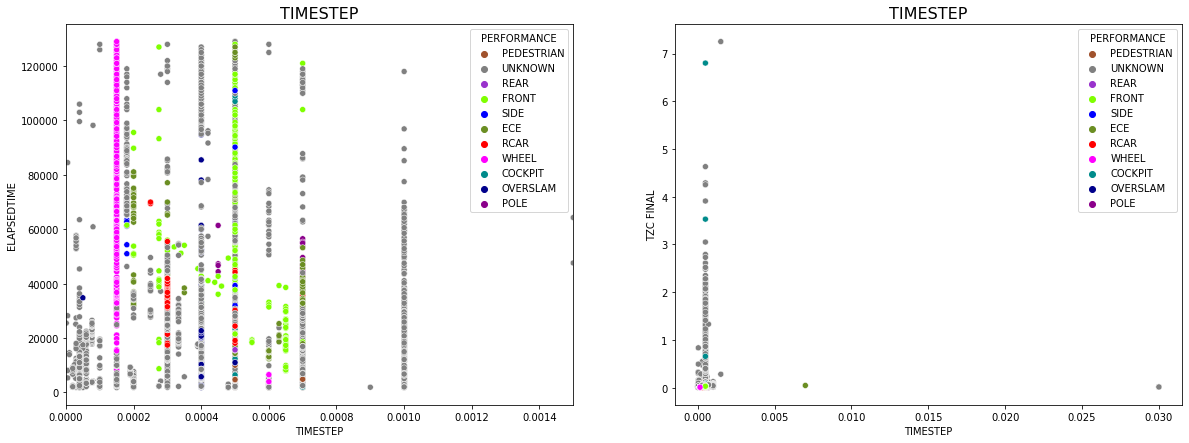

In [27]:
feature = 'TIMESTEP'

plt.figure(figsize=(20, 7))

color_palette = {'UNKNOWN': 'gray',
                 'PEDESTRIAN': 'sienna',
                 'FRONT': 'chartreuse',
                 'ECE': 'olivedrab',
                 'COCKPIT': 'darkcyan',
                 'SIDE': 'blue',
                 'OVERSLAM': 'darkblue',
                 'RCAR': 'red',
                 'REAR': 'darkorchid',
                 'WHEEL': 'fuchsia',
                 'POLE': 'darkmagenta'}

plt.subplot(1,2,1)
sns.scatterplot(x=feature, y='ELAPSEDTIME', hue='PERFORMANCE', data=train, palette=color_palette)
plt.xlim(0, 0.0015)
plt.title(f'{feature}', size=16)

plt.subplot(1,2,2)
sns.scatterplot(x=feature, y='TZC FINAL', hue='PERFORMANCE', data=train, palette=color_palette)
# plt.xlim(0.005)
plt.title(f'{feature}', size=16)
plt.show()

plt.show()

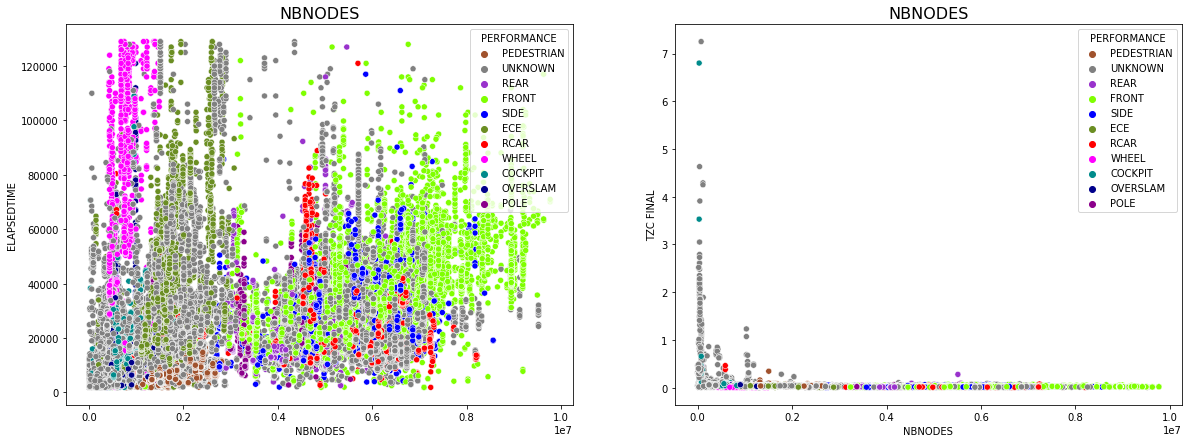

In [28]:
feature = 'NBNODES'

plt.figure(figsize=(20, 7))

color_palette = {'UNKNOWN': 'gray',
                 'PEDESTRIAN': 'sienna',
                 'FRONT': 'chartreuse',
                 'ECE': 'olivedrab',
                 'COCKPIT': 'darkcyan',
                 'SIDE': 'blue',
                 'OVERSLAM': 'darkblue',
                 'RCAR': 'red',
                 'REAR': 'darkorchid',
                 'WHEEL': 'fuchsia',
                 'POLE': 'darkmagenta'}

plt.subplot(1,2,1)
sns.scatterplot(x=feature, y='ELAPSEDTIME', hue='PERFORMANCE', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)

plt.subplot(1,2,2)
sns.scatterplot(x=feature, y='TZC FINAL', hue='PERFORMANCE', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)
plt.show()

plt.show()

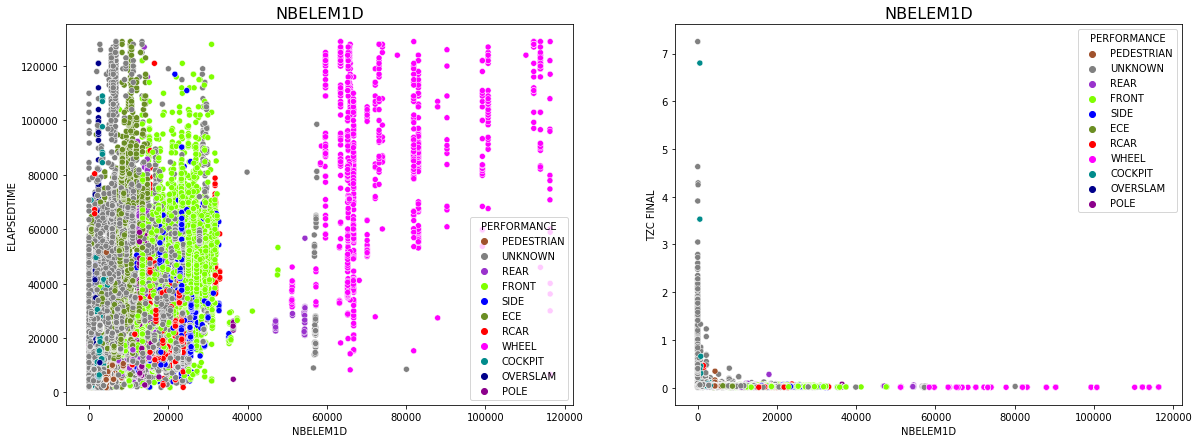

In [29]:
feature = 'NBELEM1D'

plt.figure(figsize=(20, 7))

color_palette = {'UNKNOWN': 'gray',
                 'PEDESTRIAN': 'sienna',
                 'FRONT': 'chartreuse',
                 'ECE': 'olivedrab',
                 'COCKPIT': 'darkcyan',
                 'SIDE': 'blue',
                 'OVERSLAM': 'darkblue',
                 'RCAR': 'red',
                 'REAR': 'darkorchid',
                 'WHEEL': 'fuchsia',
                 'POLE': 'darkmagenta'}

plt.subplot(1,2,1)
sns.scatterplot(x=feature, y='ELAPSEDTIME', hue='PERFORMANCE', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)

plt.subplot(1,2,2)
sns.scatterplot(x=feature, y='TZC FINAL', hue='PERFORMANCE', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)
plt.show()

plt.show()

Juntando as informações do gráfico de dispersão onde vemos NBELEM1D x ELAPSEDTIME agrupados por PRECISION e PERFORMANCE, vemos que quase todas as simulações de precisão dupla são simulações de rodas. Talvez isso seja relevante em algum momento

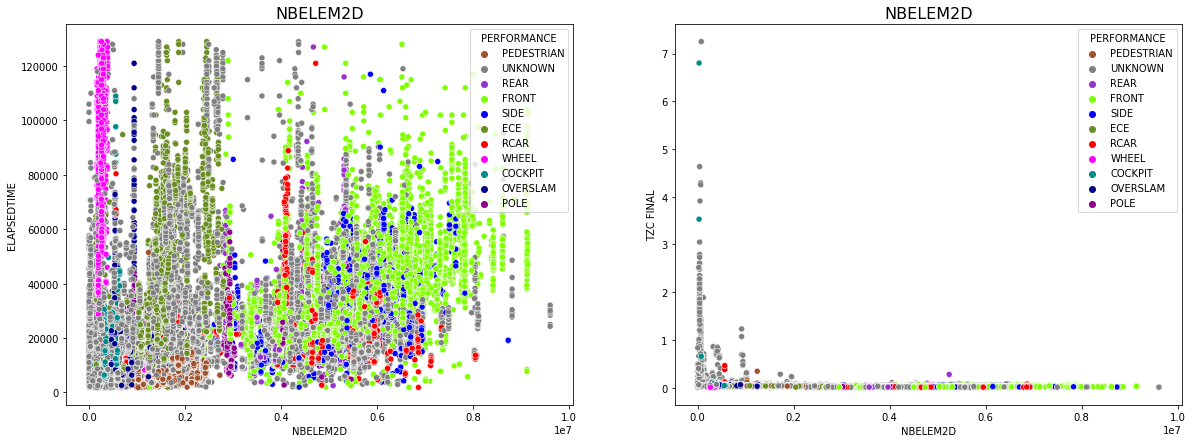

In [30]:
feature = 'NBELEM2D'

plt.figure(figsize=(20, 7))

color_palette = {'UNKNOWN': 'gray',
                 'PEDESTRIAN': 'sienna',
                 'FRONT': 'chartreuse',
                 'ECE': 'olivedrab',
                 'COCKPIT': 'darkcyan',
                 'SIDE': 'blue',
                 'OVERSLAM': 'darkblue',
                 'RCAR': 'red',
                 'REAR': 'darkorchid',
                 'WHEEL': 'fuchsia',
                 'POLE': 'darkmagenta'}

plt.subplot(1,2,1)
sns.scatterplot(x=feature, y='ELAPSEDTIME', hue='PERFORMANCE', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)

plt.subplot(1,2,2)
sns.scatterplot(x=feature, y='TZC FINAL', hue='PERFORMANCE', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)
plt.show()

plt.show()

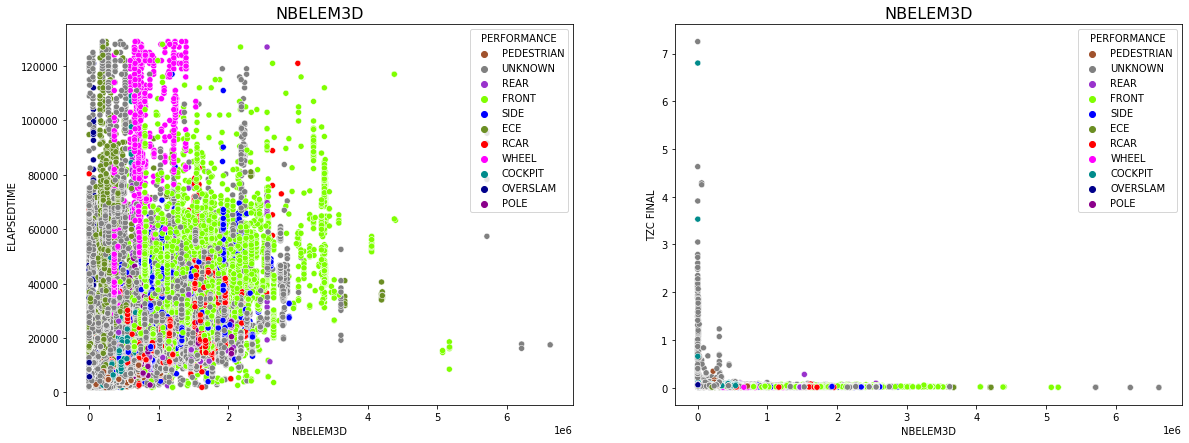

In [31]:
feature = 'NBELEM3D'

plt.figure(figsize=(20, 7))

color_palette = {'UNKNOWN': 'gray',
                 'PEDESTRIAN': 'sienna',
                 'FRONT': 'chartreuse',
                 'ECE': 'olivedrab',
                 'COCKPIT': 'darkcyan',
                 'SIDE': 'blue',
                 'OVERSLAM': 'darkblue',
                 'RCAR': 'red',
                 'REAR': 'darkorchid',
                 'WHEEL': 'fuchsia',
                 'POLE': 'darkmagenta'}

plt.subplot(1,2,1)
sns.scatterplot(x=feature, y='ELAPSEDTIME', hue='PERFORMANCE', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)

plt.subplot(1,2,2)
sns.scatterplot(x=feature, y='TZC FINAL', hue='PERFORMANCE', data=train, palette=color_palette)
plt.title(f'{feature}', size=16)
plt.show()

plt.show()

#### PERFORMANCE: WHEEL

In [32]:
# dados de trino filtrados apenas para simulações de roda
train_wheel = train[train['PERFORMANCE'] == 'WHEEL']
train_wheel

JOBID         DAY      HOUR  ... DATACHECK_TIME ELAPSEDTIME  TZC FINAL
66     829458  01/02/2019  07:04:05  ...           19.2       93700    0.01080
243    834136  01/03/2019  12:29:48  ...           21.0       83100    0.01090
262    832945  01/03/2019  10:22:02  ...           19.0       94300    0.01090
661    852521  01/07/2019  04:22:46  ...           21.0       90600    0.01110
809    860234  01/08/2019  04:26:15  ...           17.0       49400    0.00905
...       ...         ...       ...  ...            ...         ...        ...
88982  996757  07/30/2020  14:55:56  ...           20.1       40500    0.00932
88989  991522  07/30/2020  07:39:09  ...           30.4       71100    0.00668
88995  991211  07/30/2020  07:10:12  ...           29.7       78600    0.00851
88996  996779  07/30/2020  14:57:29  ...           20.2       50800    0.00931
89111  992614  07/31/2020  23:58:26  ...           28.3      129000    0.00845

[1315 rows x 22 columns]

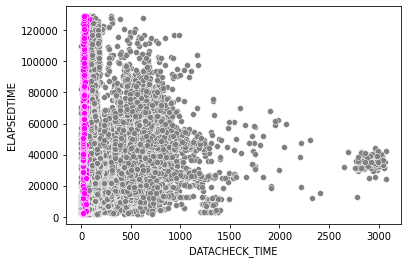

In [67]:
"""
color_palette = {'UNKNOWN': 'gray',
                 'PEDESTRIAN': 'sienna',
                 'FRONT': 'chartreuse',
                 'ECE': 'olivedrab',
                 'COCKPIT': 'darkcyan',
                 'SIDE': 'blue',
                 'OVERSLAM': 'darkblue',
                 'RCAR': 'red',
                 'REAR': 'darkorchid',
                 'WHEEL': 'fuchsia',
                 'POLE': 'darkmagenta'}
"""

sns.scatterplot(x='DATACHECK_TIME', y="ELAPSEDTIME", data=train, color='gray')
sns.scatterplot(x='DATACHECK_TIME', y="ELAPSEDTIME", data=train_wheel, color='fuchsia')
plt.show()

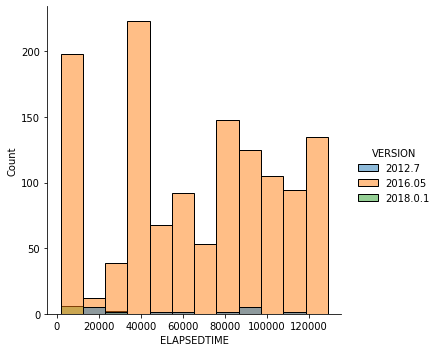

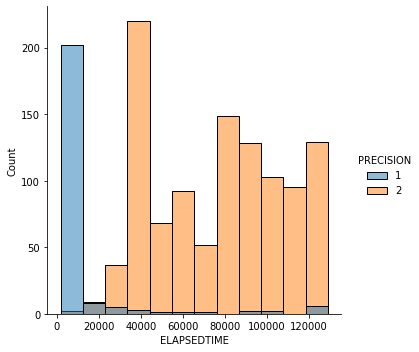

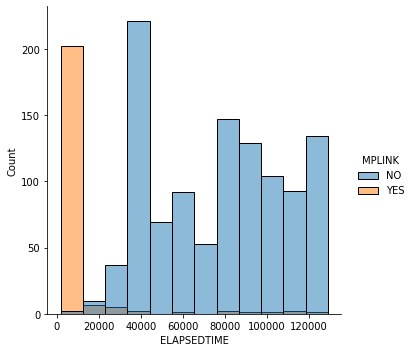

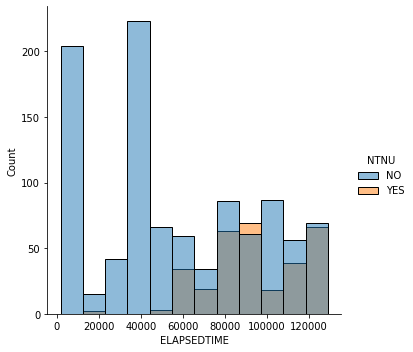

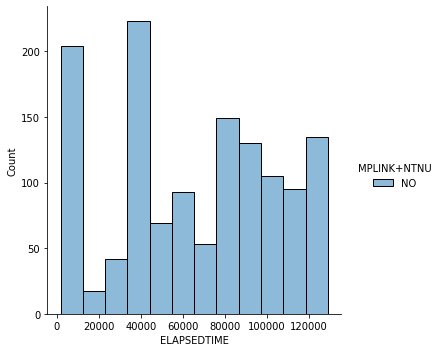

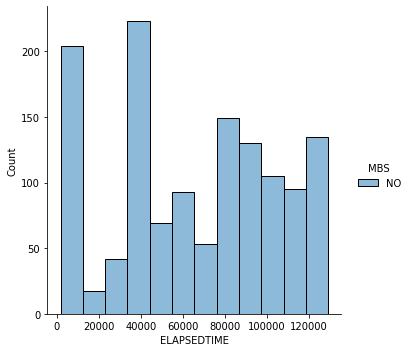

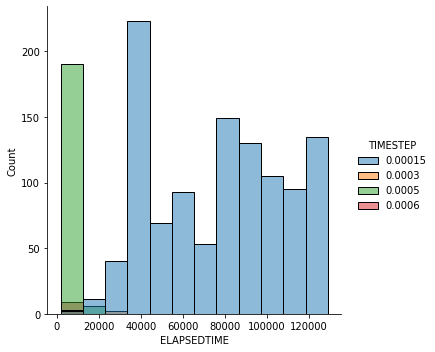

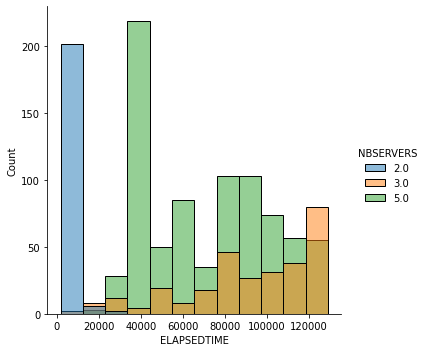

In [56]:
columns = ['VERSION', 'PRECISION', 'MPLINK', 'NTNU', 'MPLINK+NTNU', 'MBS', 'TIMESTEP', 'NBSERVERS']
for column in columns:
  sns.displot(x="ELAPSEDTIME", data=train_wheel, hue=column, palette='tab10')

Temos 1315 simulações de rodas 

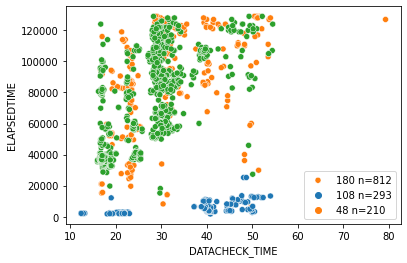

In [33]:
sns.scatterplot(x="DATACHECK_TIME", y="ELAPSEDTIME", data=train_wheel, hue='NBCORE', palette='tab10')

lista_legenda = []
for idx in train_wheel.NBCORE.value_counts().index:
  legenda = f'{idx} n={train_wheel.NBCORE.value_counts().loc[idx]}'
  lista_legenda.append(legenda)

plt.legend(lista_legenda)
plt.show()

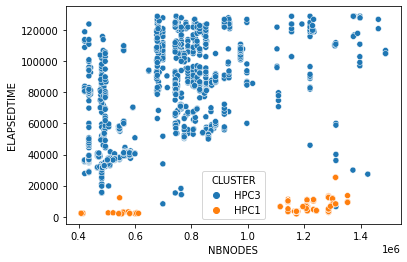

In [34]:
sns.scatterplot(x="NBNODES", y="ELAPSEDTIME", data=train_wheel, hue='CLUSTER', palette='tab10')
plt.show()

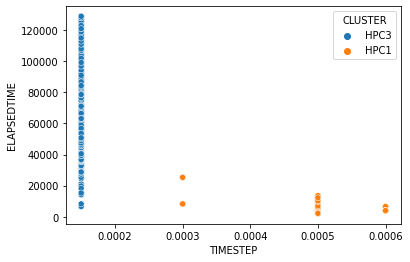

In [35]:
sns.scatterplot(x="TIMESTEP", y="ELAPSEDTIME", data=train_wheel, hue='CLUSTER', palette='tab10')
plt.show()

Simulações mais curtas acontecem em clusters mais antigos com iterações mais longas

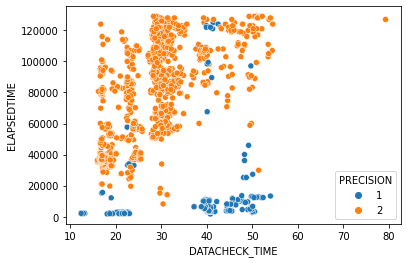

In [36]:
sns.scatterplot(x="DATACHECK_TIME", y="ELAPSEDTIME", data=train_wheel, hue='PRECISION', palette='tab10')
plt.show()

Aquela ideia de que quanto mais complexa a simulação, menor o datacheck time, parece se confirmar

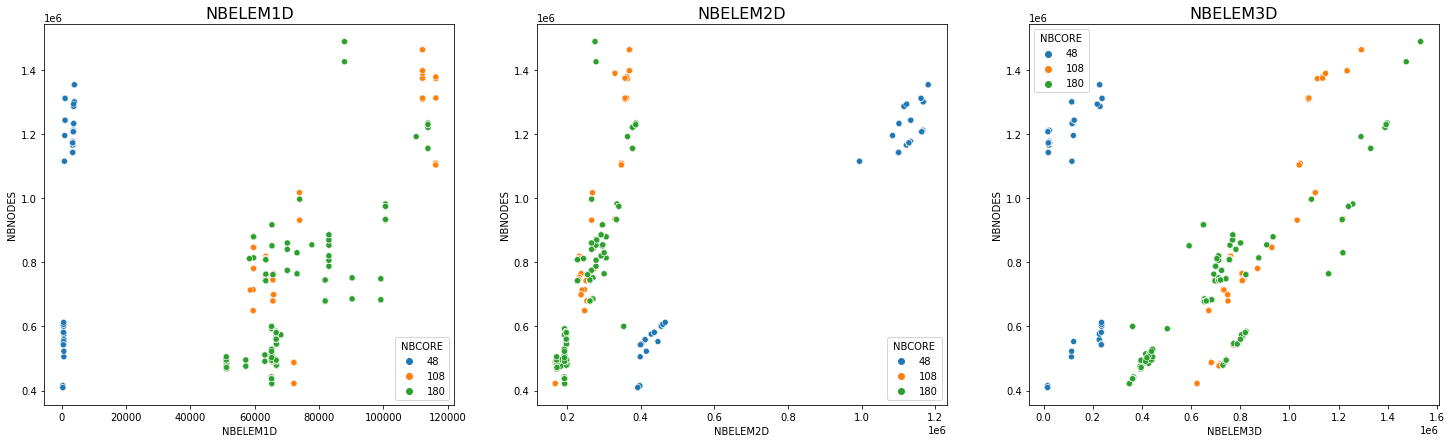

In [37]:
plt.figure(figsize=(25, 7 ))

plt.subplot(1,3,1)
sns.scatterplot(x="NBELEM1D", y="NBNODES", data=train_wheel, hue='NBCORE', palette='tab10')
plt.title('NBELEM1D', size=16)

plt.subplot(1,3,2)
sns.scatterplot(x="NBELEM2D", y="NBNODES", data=train_wheel, hue='NBCORE', palette='tab10')
plt.title('NBELEM2D', size=16)

plt.subplot(1,3,3)
sns.scatterplot(x="NBELEM3D", y="NBNODES", data=train_wheel, hue='NBCORE', palette='tab10')
plt.title("NBELEM3D", size=16)

plt.show()

Aparentemente existe uma separação bem clara entre simulações de 48 cores e o outro grupo que ainda aparece bastance emaranhado

Nesse caso, talvez valha mais a pensa usar a informação de cluster já que 48 é múltiplo de 24 enquanto 108 e 180 são múltiplos de 36

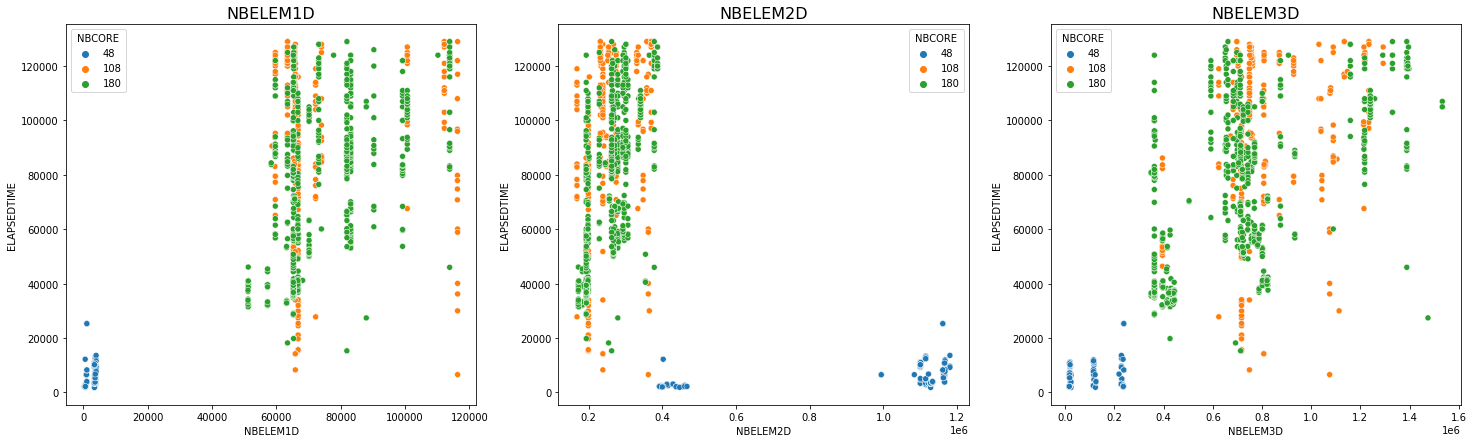

In [38]:
plt.figure(figsize=(25, 7 ))

plt.subplot(1,3,1)
sns.scatterplot(x="NBELEM1D", y="ELAPSEDTIME", data=train_wheel, hue='NBCORE', palette='tab10')
plt.title('NBELEM1D', size=16)

plt.subplot(1,3,2)
sns.scatterplot(x="NBELEM2D", y="ELAPSEDTIME", data=train_wheel, hue='NBCORE', palette='tab10')
plt.title('NBELEM2D', size=16)

plt.subplot(1,3,3)
sns.scatterplot(x="NBELEM3D", y="ELAPSEDTIME", data=train_wheel, hue='NBCORE', palette='tab10')
plt.title("NBELEM3D", size=16)

plt.show()

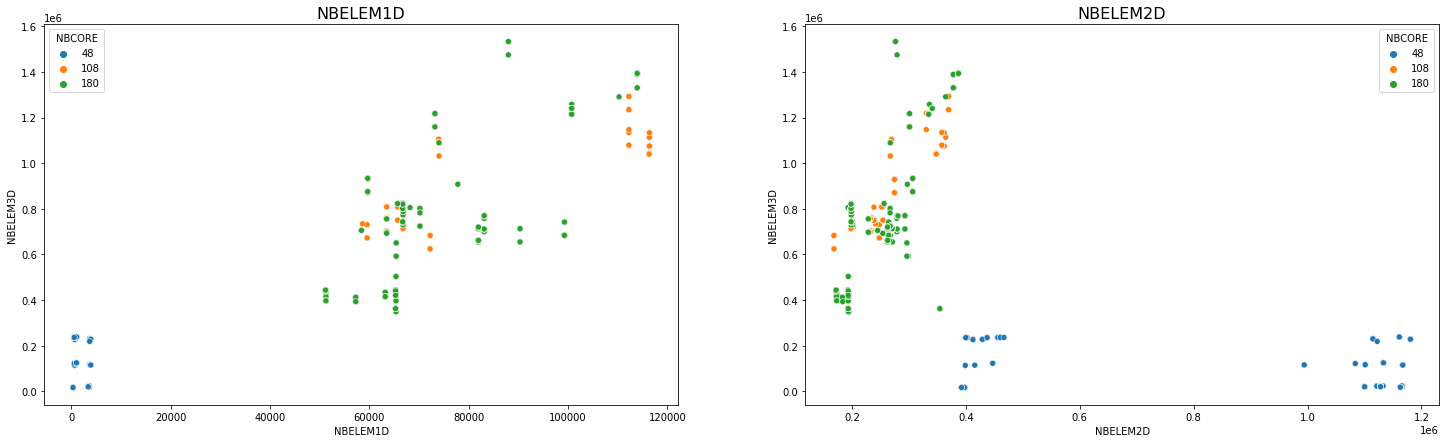

In [39]:
plt.figure(figsize=(25, 7 ))

plt.subplot(1,2,1)
sns.scatterplot(x="NBELEM1D", y="NBELEM3D", data=train_wheel, hue='NBCORE', palette='tab10')
plt.title('NBELEM1D', size=16)

plt.subplot(1,2,2)
sns.scatterplot(x="NBELEM2D", y="NBELEM3D", data=train_wheel, hue='NBCORE', palette='tab10')
plt.title('NBELEM2D', size=16)

plt.show()

In [40]:
train_wheel.NBSERVERS.value_counts()

5.0    812
3.0    293
2.0    210
Name: NBSERVERS, dtype: int64

#### PERFORMANCE: PEDESTRIAN

In [41]:
train_pedestrian = train[train['PERFORMANCE'] == 'PEDESTRIAN']
train_pedestrian

JOBID         DAY      HOUR  ... DATACHECK_TIME ELAPSEDTIME  TZC FINAL
0      829925  01/02/2019  10:04:18  ...           70.5        2920     0.0398
15     830909  01/02/2019  14:56:15  ...          138.0        6590     0.0306
67     832011  01/03/2019  08:03:17  ...          114.0        5740     0.0336
74     833242  01/03/2019  10:56:23  ...           83.3        3180     0.0345
89     834021  01/03/2019  12:14:54  ...          189.0        6360     0.0396
...       ...         ...       ...  ...            ...         ...        ...
89033    4836  07/31/2020  20:42:08  ...           76.1        4660     0.0348
89034    4830  07/31/2020  20:40:12  ...           75.8        4800     0.0358
89035    4840  07/31/2020  20:43:46  ...           75.8        4610     0.0344
89036    4846  07/31/2020  20:44:57  ...           75.8        4660     0.0348
89037    4844  07/31/2020  20:44:43  ...           76.6        4730     0.0353

[15301 rows x 22 columns]

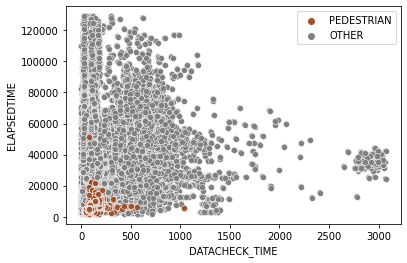

In [66]:
"""
color_palette = {'UNKNOWN': 'gray',
                 'PEDESTRIAN': 'sienna',
                 'FRONT': 'chartreuse',
                 'ECE': 'olivedrab',
                 'COCKPIT': 'darkcyan',
                 'SIDE': 'blue',
                 'OVERSLAM': 'darkblue',
                 'RCAR': 'red',
                 'REAR': 'darkorchid',
                 'WHEEL': 'fuchsia',
                 'POLE': 'darkmagenta'}
"""

sns.scatterplot(x='DATACHECK_TIME', y="ELAPSEDTIME", data=train, color='gray')
sns.scatterplot(x='DATACHECK_TIME', y="ELAPSEDTIME", data=train_pedestrian, color='sienna')
plt.show()

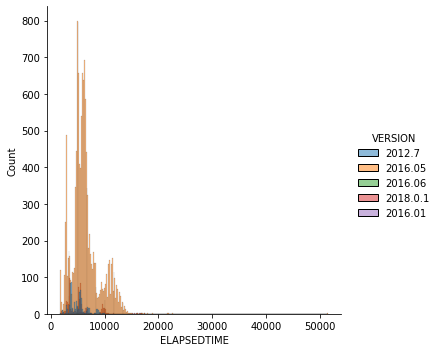

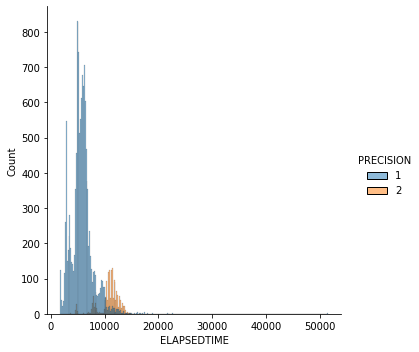

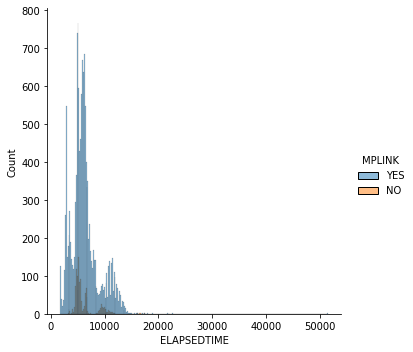

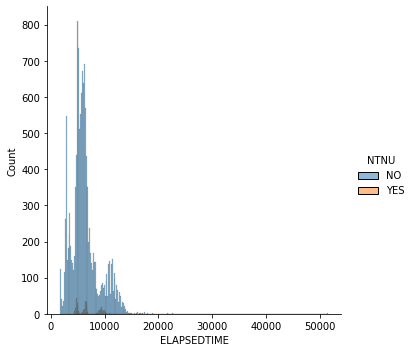

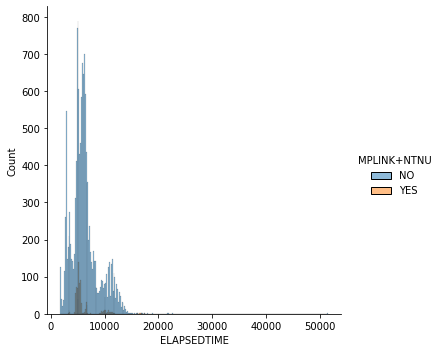

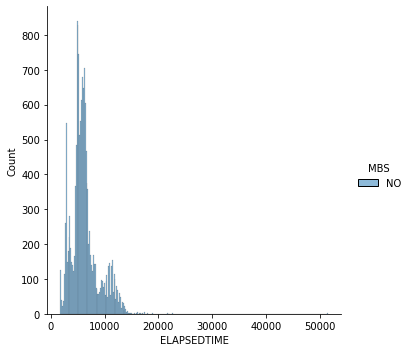

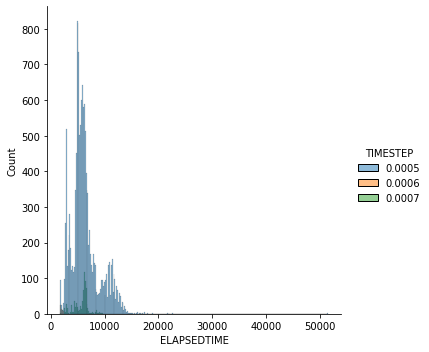

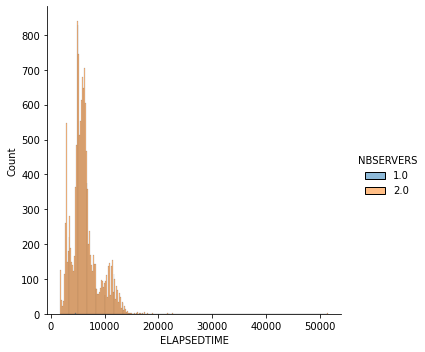

In [57]:
columns = ['VERSION', 'PRECISION', 'MPLINK', 'NTNU', 'MPLINK+NTNU', 'MBS', 'TIMESTEP', 'NBSERVERS']
for column in columns:
  sns.displot(x="ELAPSEDTIME", data=train_pedestrian, hue=column, palette='tab10')

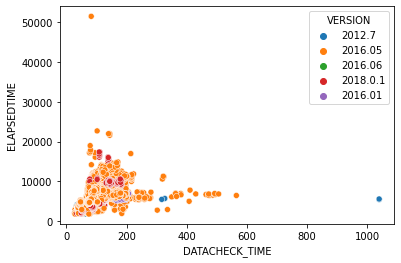

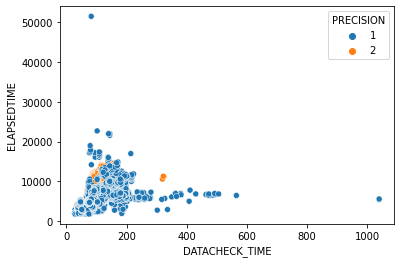

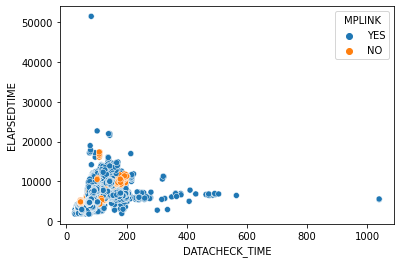

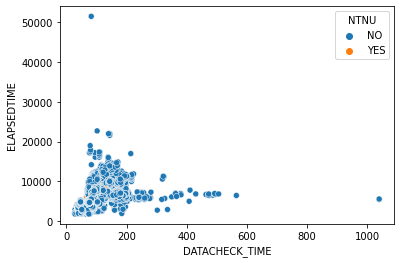

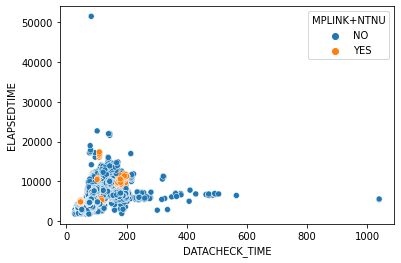

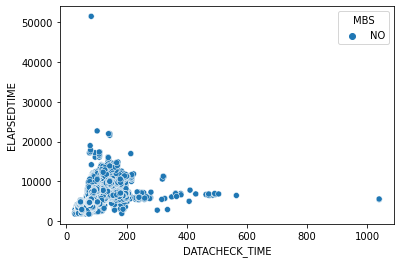

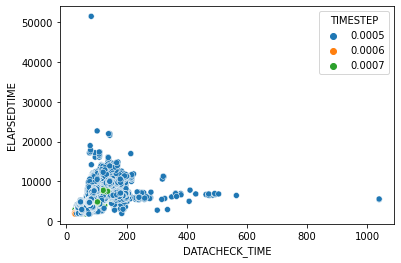

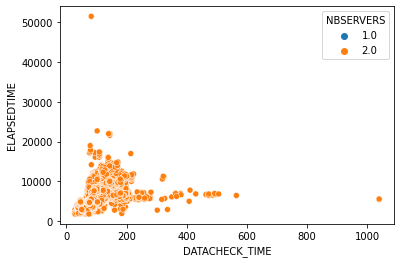

In [42]:
columns = ['VERSION', 'PRECISION', 'MPLINK', 'NTNU', 'MPLINK+NTNU', 'MBS', 'TIMESTEP', 'NBSERVERS']
for column in columns:
  sns.scatterplot(x="DATACHECK_TIME", y="ELAPSEDTIME", data=train_pedestrian, hue=column, palette='tab10')

  # lista_legenda = []
  # for idx in train_pedestrian[column].value_counts().index:
  #   legenda = f'{idx} n={train_pedestrian[column].value_counts().loc[idx]}'
  #   lista_legenda.append(legenda)

  # plt.legend(lista_legenda, title=column)

  plt.show()

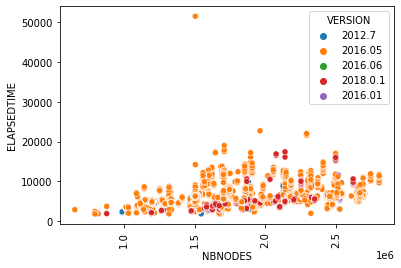

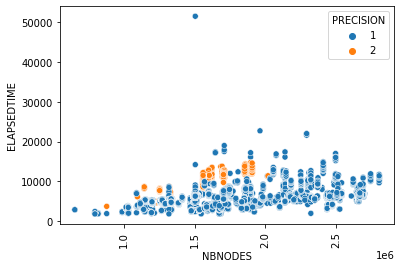

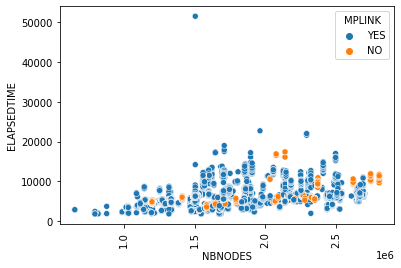

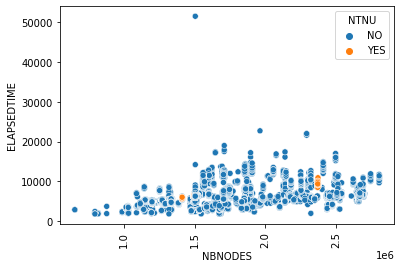

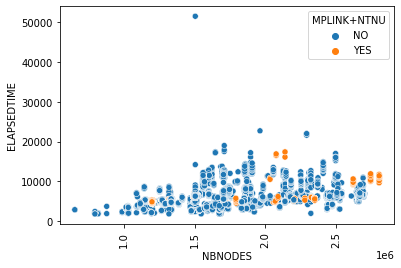

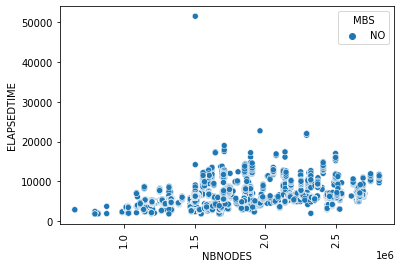

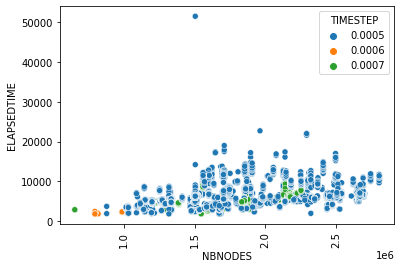

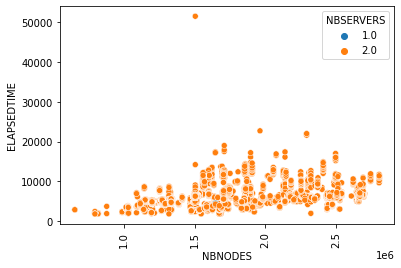

In [43]:
columns = ['VERSION', 'PRECISION', 'MPLINK', 'NTNU', 'MPLINK+NTNU', 'MBS', 'TIMESTEP', 'NBSERVERS']
for column in columns:
  sns.scatterplot(x="NBNODES", y="ELAPSEDTIME", data=train_pedestrian, hue=column, palette='tab10')

  plt.xticks(rotation=90)

  plt.show()

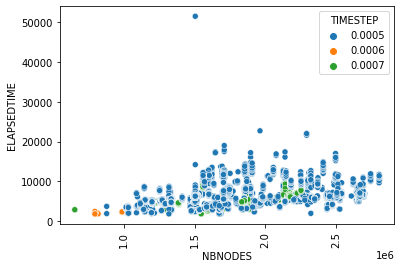

In [44]:
sns.scatterplot(x="NBNODES", y="ELAPSEDTIME", data=train_pedestrian, hue='TIMESTEP', palette='tab10')
plt.xticks(rotation=90)
plt.show()

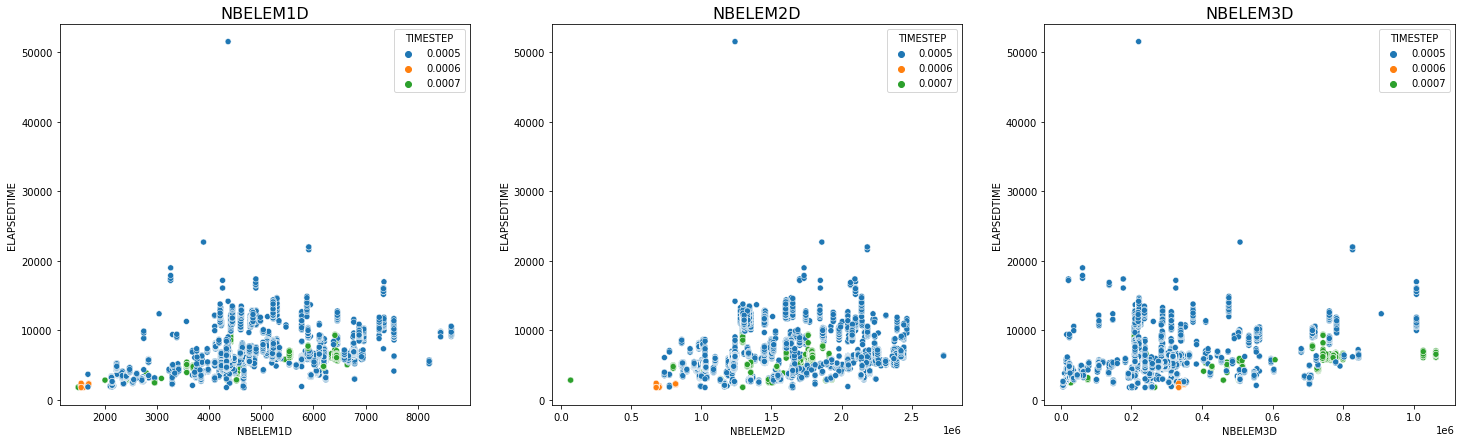

In [45]:
plt.figure(figsize=(25, 7 ))

plt.subplot(1,3,1)
sns.scatterplot(x="NBELEM1D", y="ELAPSEDTIME", data=train_pedestrian, hue='TIMESTEP', palette='tab10')
plt.title('NBELEM1D', size=16)

plt.subplot(1,3,2)
sns.scatterplot(x="NBELEM2D", y="ELAPSEDTIME", data=train_pedestrian, hue='TIMESTEP', palette='tab10')
plt.title('NBELEM2D', size=16)

plt.subplot(1,3,3)
sns.scatterplot(x="NBELEM3D", y="ELAPSEDTIME", data=train_pedestrian, hue='TIMESTEP', palette='tab10')
plt.title("NBELEM3D", size=16)

plt.show()

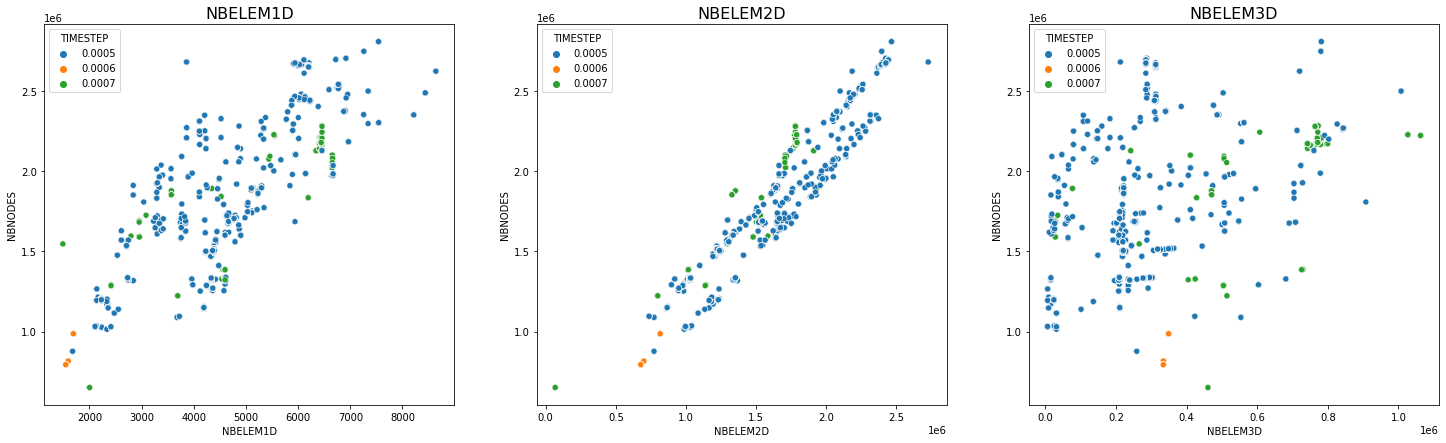

In [46]:
plt.figure(figsize=(25, 7 ))

plt.subplot(1,3,1)
sns.scatterplot(x="NBELEM1D", y="NBNODES", data=train_pedestrian, hue='TIMESTEP', palette='tab10')
plt.title('NBELEM1D', size=16)

plt.subplot(1,3,2)
sns.scatterplot(x="NBELEM2D", y="NBNODES", data=train_pedestrian, hue='TIMESTEP', palette='tab10')
plt.title('NBELEM2D', size=16)

plt.subplot(1,3,3)
sns.scatterplot(x="NBELEM3D", y="NBNODES", data=train_pedestrian, hue='TIMESTEP', palette='tab10')
plt.title("NBELEM3D", size=16)

plt.show()

In [55]:
from sklearn.ensemble import RandomForestRegressor

train_pedestrian['ELAPSEDTIME'].describe()

count    15301.000000
mean      6259.114437
std       2511.624757
min       1810.000000
25%       4890.000000
50%       5820.000000
75%       6970.000000
max      51500.000000
Name: ELAPSEDTIME, dtype: float64